# Устанавливаем библиотеки

In [1]:
! pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 12.5 MB/s eta 0:00:00


In [2]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np

In [69]:
import timeit

In [86]:
import matplotlib.pyplot as plt

# Реализация алгоритмов

In [55]:
def naiveA3(A):
  A_2 = A.mxm(A)
  A_3 = A_2.mxm(A)
  diag = A_3.diag()
  result = int((diag.reduce(gb.agg.sum).value or 0) / 6)
  return result

def naiveMaskA2(A):
    A_2 = A.mxm(A)
    A_M = A_2.dup(mask=A.dup(dtype=dtypes.BOOL))
    result = int((A_M.reduce_scalar(gb.monoid.plus).value or 0) / 6)
    return result

def cohen(A):
    L = gb.select.tril(A)
    U = gb.select.triu(A)
    C = L.mxm(U)
    C_M = C.dup(mask=A.dup(dtype=dtypes.BOOL))
    result=int((C_M.reduce_scalar(gb.monoid.plus).value or 0)/2)
    return result

def sandia(A):
    L=gb.select.tril(A)
    C=L.mxm(L).dup(mask=L.dup(dtype=dtypes.BOOL))
    result=int(C.reduce_scalar(gb.monoid.plus).value or 0)
    return result

# функция, вычисляющая для каждой вершины неориентированного графа количество треугольников, в которых она участвует
def triangles(A):
    diag = A.mxm(A.mxm(A)).diag()/2
    result = []
    for i in range(diag.size):
      result.append(int(diag[i].value or 0))
    return result

Тестируем на двух матрицах

In [25]:
adjacency_matrix = np.array([
    [0, 1, 0, 1, 0, 0],
    [1, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1],
    [1, 1, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 1],
    [0, 0, 1, 1, 1, 0]

])

graph = gb.Matrix.from_dense(adjacency_matrix,missing_value=0)

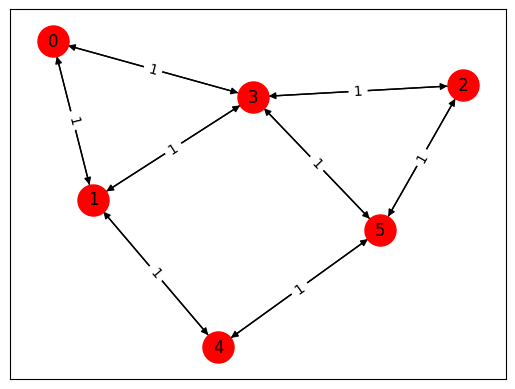

In [26]:
gb.viz.draw(graph)

Первый граф с 2 треугольниками

In [30]:
adjacency_matrix2 = np.array([
    [0, 1, 0, 1, 0, 0],
    [1, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [1, 1, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 1],
    [0, 1, 1, 1, 1, 0]
])

graph2 = gb.Matrix.from_dense(adjacency_matrix2, missing_value=0)

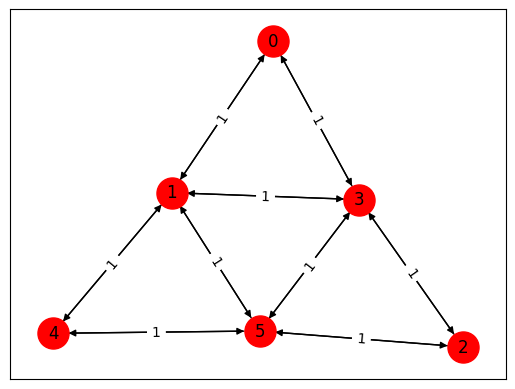

In [31]:
gb.viz.draw(graph2)

Второй граф с 5 треугольниками

In [57]:
def test(A):
    result = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(element == element for element in result):
       print("All return values are not equal")
    else:
       print("All return values are equal")

In [58]:
test(graph)
test(graph2)

[2, 2, 2, 2]
All return values are equal
[4, 4, 4, 4]
All return values are equal


Количество треугольников для каждой вершины

In [52]:
triangles(graph)

[1, 1, 1, 2, 0, 1]

In [48]:
triangles(graph2)

[1, 3, 1, 3, 1, 3]

Всё хорошо

# Тестирование на матрицах с сайта

In [61]:
M1 = mmread('bcspwr10.mtx')
M2 = mmread('lshp2614.mtx')
M3 = mmread('lshp1882.mtx')
M4 = mmread('lshp2233.mtx')
M5 = mmread('dwt_2680.mtx')
M6 = mmread('dwt_1242.mtx')
M7 = mmread('can_838.mtx')
M8 = mmread('can_1054.mtx')
M9 = mmread('blckhole.mtx')
M10 = mmread('bcspwr10.mtx')

In [62]:
Matrices = [M1, M2, M3, M4, M5, M6, M7, M8, M9, M10]

In [117]:
def test_matrices(Matrices, labels):
  alg = ['naiveA3', 'naiveMaskA2', 'cohen', 'sandia']
  for i in range(len(Matrices)):
    results = []
    results.append(timeit.timeit(lambda:naiveA3(Matrices[i]), number=5))
    results.append(timeit.timeit(lambda:naiveMaskA2(Matrices[i]), number=5))
    results.append(timeit.timeit(lambda:cohen(Matrices[i]), number=5))
    results.append(timeit.timeit(lambda:sandia(Matrices[i]), number=5))

    plt.plot(alg, results, label=labels[i])

  plt.xlabel('Алгоритмы')
  plt.ylabel('Время')
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

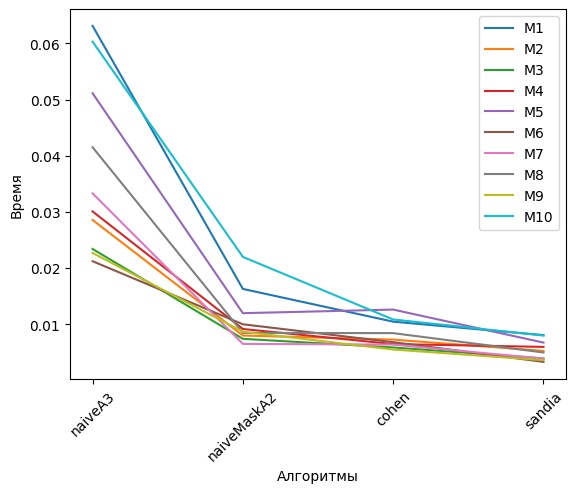

In [119]:
test_matrices(Matrices, ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10'])

Сравнение алгоритмов показало, что наиболее оптимальным по времени алгоритмом является Sandia, наименее оптимальным - наивный алгоритм без маски

# Генератор неориентированных графов

Функция генерации случайного неориентированного графа, с заданным количеством вершин и степенью разреженности (принимает значение от 0 до 1).

In [110]:
def generate_random_graph(num_vertices, sparsity):
    adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
    np.fill_diagonal(adj_matrix, 0)
    # Вычисление количества рёбер в графе
    num_edges = int(num_vertices * (num_vertices - 1) * sparsity / 2)

    edge_count = 0
    while edge_count < num_edges:
        # Выбор вершин для ребра
        vertex1 = np.random.randint(0, num_vertices)
        vertex2 = np.random.randint(0, num_vertices)

        # Проверка, что выбранные вершины не совпадают и ребро еще не существует
        if vertex1 != vertex2 and adj_matrix[vertex1][vertex2] == 0:
            adj_matrix[vertex1][vertex2] = 1
            adj_matrix[vertex2][vertex1] = 1
            edge_count += 1

    return gb.Matrix.from_dense(adj_matrix, missing_value=0)

In [112]:
num_vertices = 6
sparsity = 0.5

random_graph = generate_random_graph(num_vertices, sparsity)
print(random_graph)

"M_12541"  nvals  nrows  ncols  dtype   format
gb.Matrix     14      6      6  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5
0                 1
1              1  1
2           1      
3        1     1  1
4     1     1     1
5  1  1     1  1   


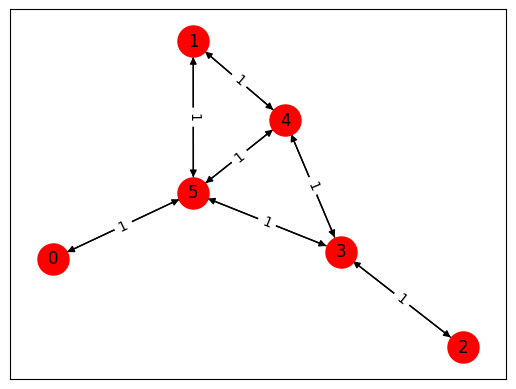

In [113]:
gb.viz.draw(random_graph)

Посмотрим как влияет размерность графа на время работы разных алгоритмов. Степень разреженности оставим одинаковой.

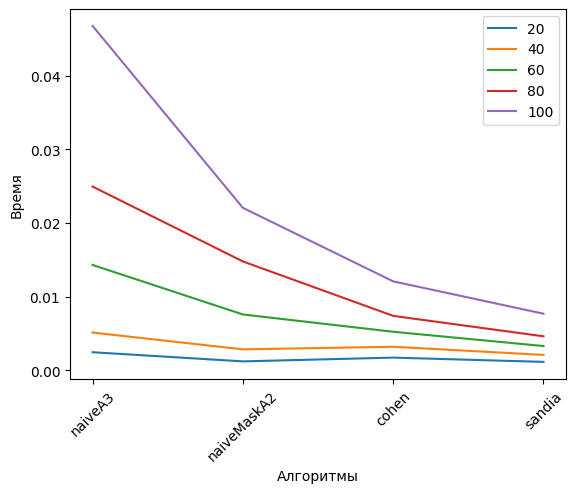

In [121]:
sparsity = 0.5

Matrices = [generate_random_graph(20, sparsity),
            generate_random_graph(40, sparsity),
            generate_random_graph(60, sparsity),
            generate_random_graph(80, sparsity),
            generate_random_graph(100, sparsity)]
test_matrices(Matrices, ['20', '40', '60', '80', '100'])

Видим, что при увеличении размерности время работы алгоритма также увеличивается.

Sandia всё ещё остаётся наиболее оптимальным алгоритмом, однако для матриц небольшой размерности наивный алгоритм с маскированием показывает аналогично хорошие результаты




Теперь размерность оставим одинаковой.
Посмотрим как влияет степень разреженности на время работы разных алгоритмов.  

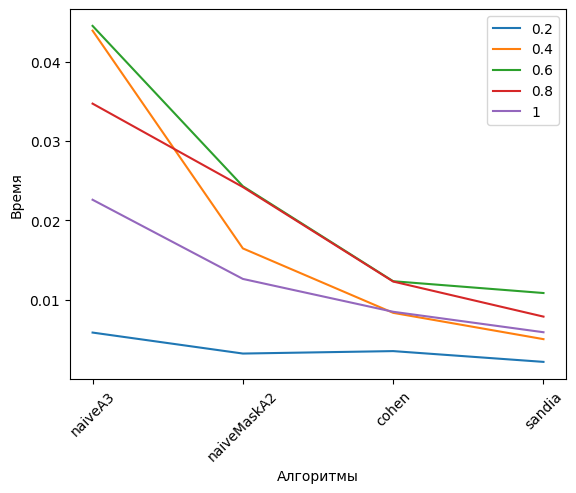

In [128]:
num_vertices = 100

Matrices = [generate_random_graph(num_vertices, 0.2),
            generate_random_graph(num_vertices, 0.4),
            generate_random_graph(num_vertices, 0.6),
            generate_random_graph(num_vertices, 0.8),
            generate_random_graph(num_vertices, 1)]
test_matrices(Matrices, ['0.2', '0.4', '0.6', '0.8', '1'])

Как и раньше, лучше всего показывает себя Sandia.
Для матриц с низкой размерностью также хорошо себя показывает наивный алгоритм с маскированием. Между степенью разреженности и временем работы алгоритмов не наблюдается линейная зависимость